<a href="https://colab.research.google.com/github/adgcal/Anjan_collab_R/blob/main/lacunarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/ranjita2024/time/")


In [4]:
!ls

Cont  Samp


In [6]:
os.chdir("/content/drive/My Drive/ranjita2024/time/Cont")


In [7]:
ls

Control_00hr.tif  Control_03hr_4.tif  Control_24.tif  Control_48.tif  Control_72.tif


In [8]:
import cv2

In [9]:
img= cv2.imread('Control_00hr.tif')

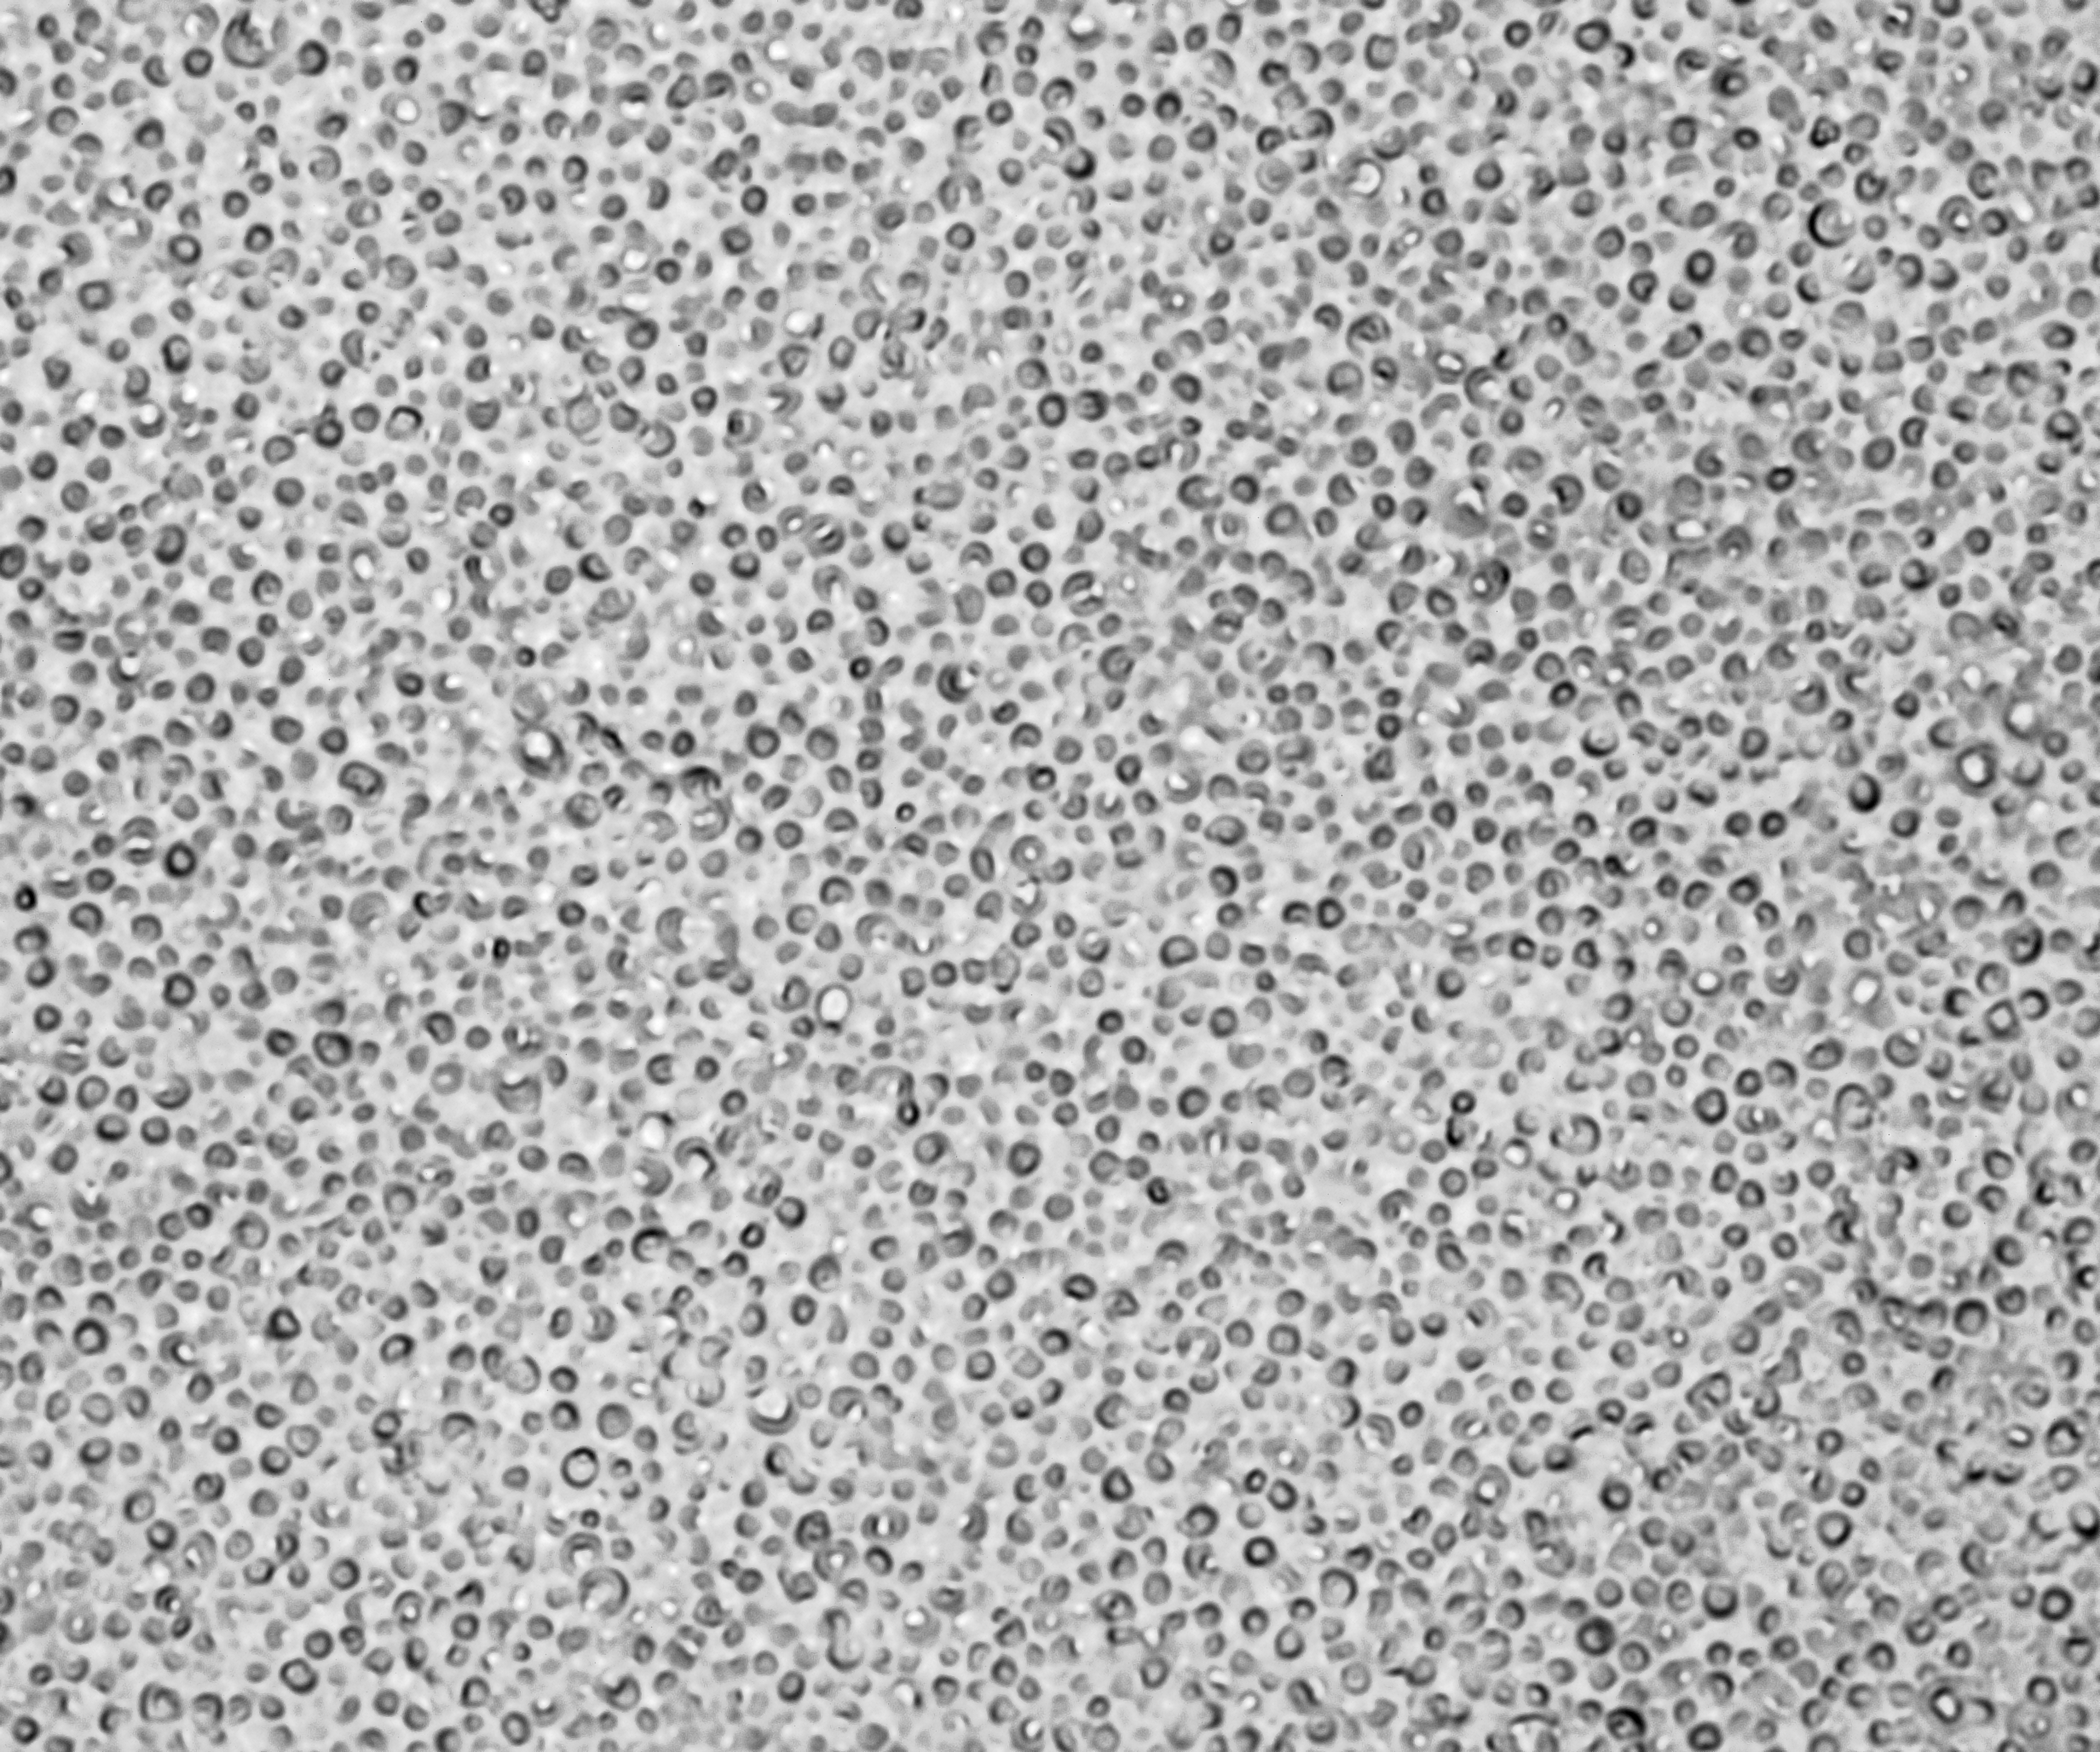

In [10]:
from google.colab.patches import cv2_imshow

if img is None:
    print("Error reading image! Please check the file path.")
else:
    # Process and display the image (assuming img is valid now)
    cv2_imshow(img)


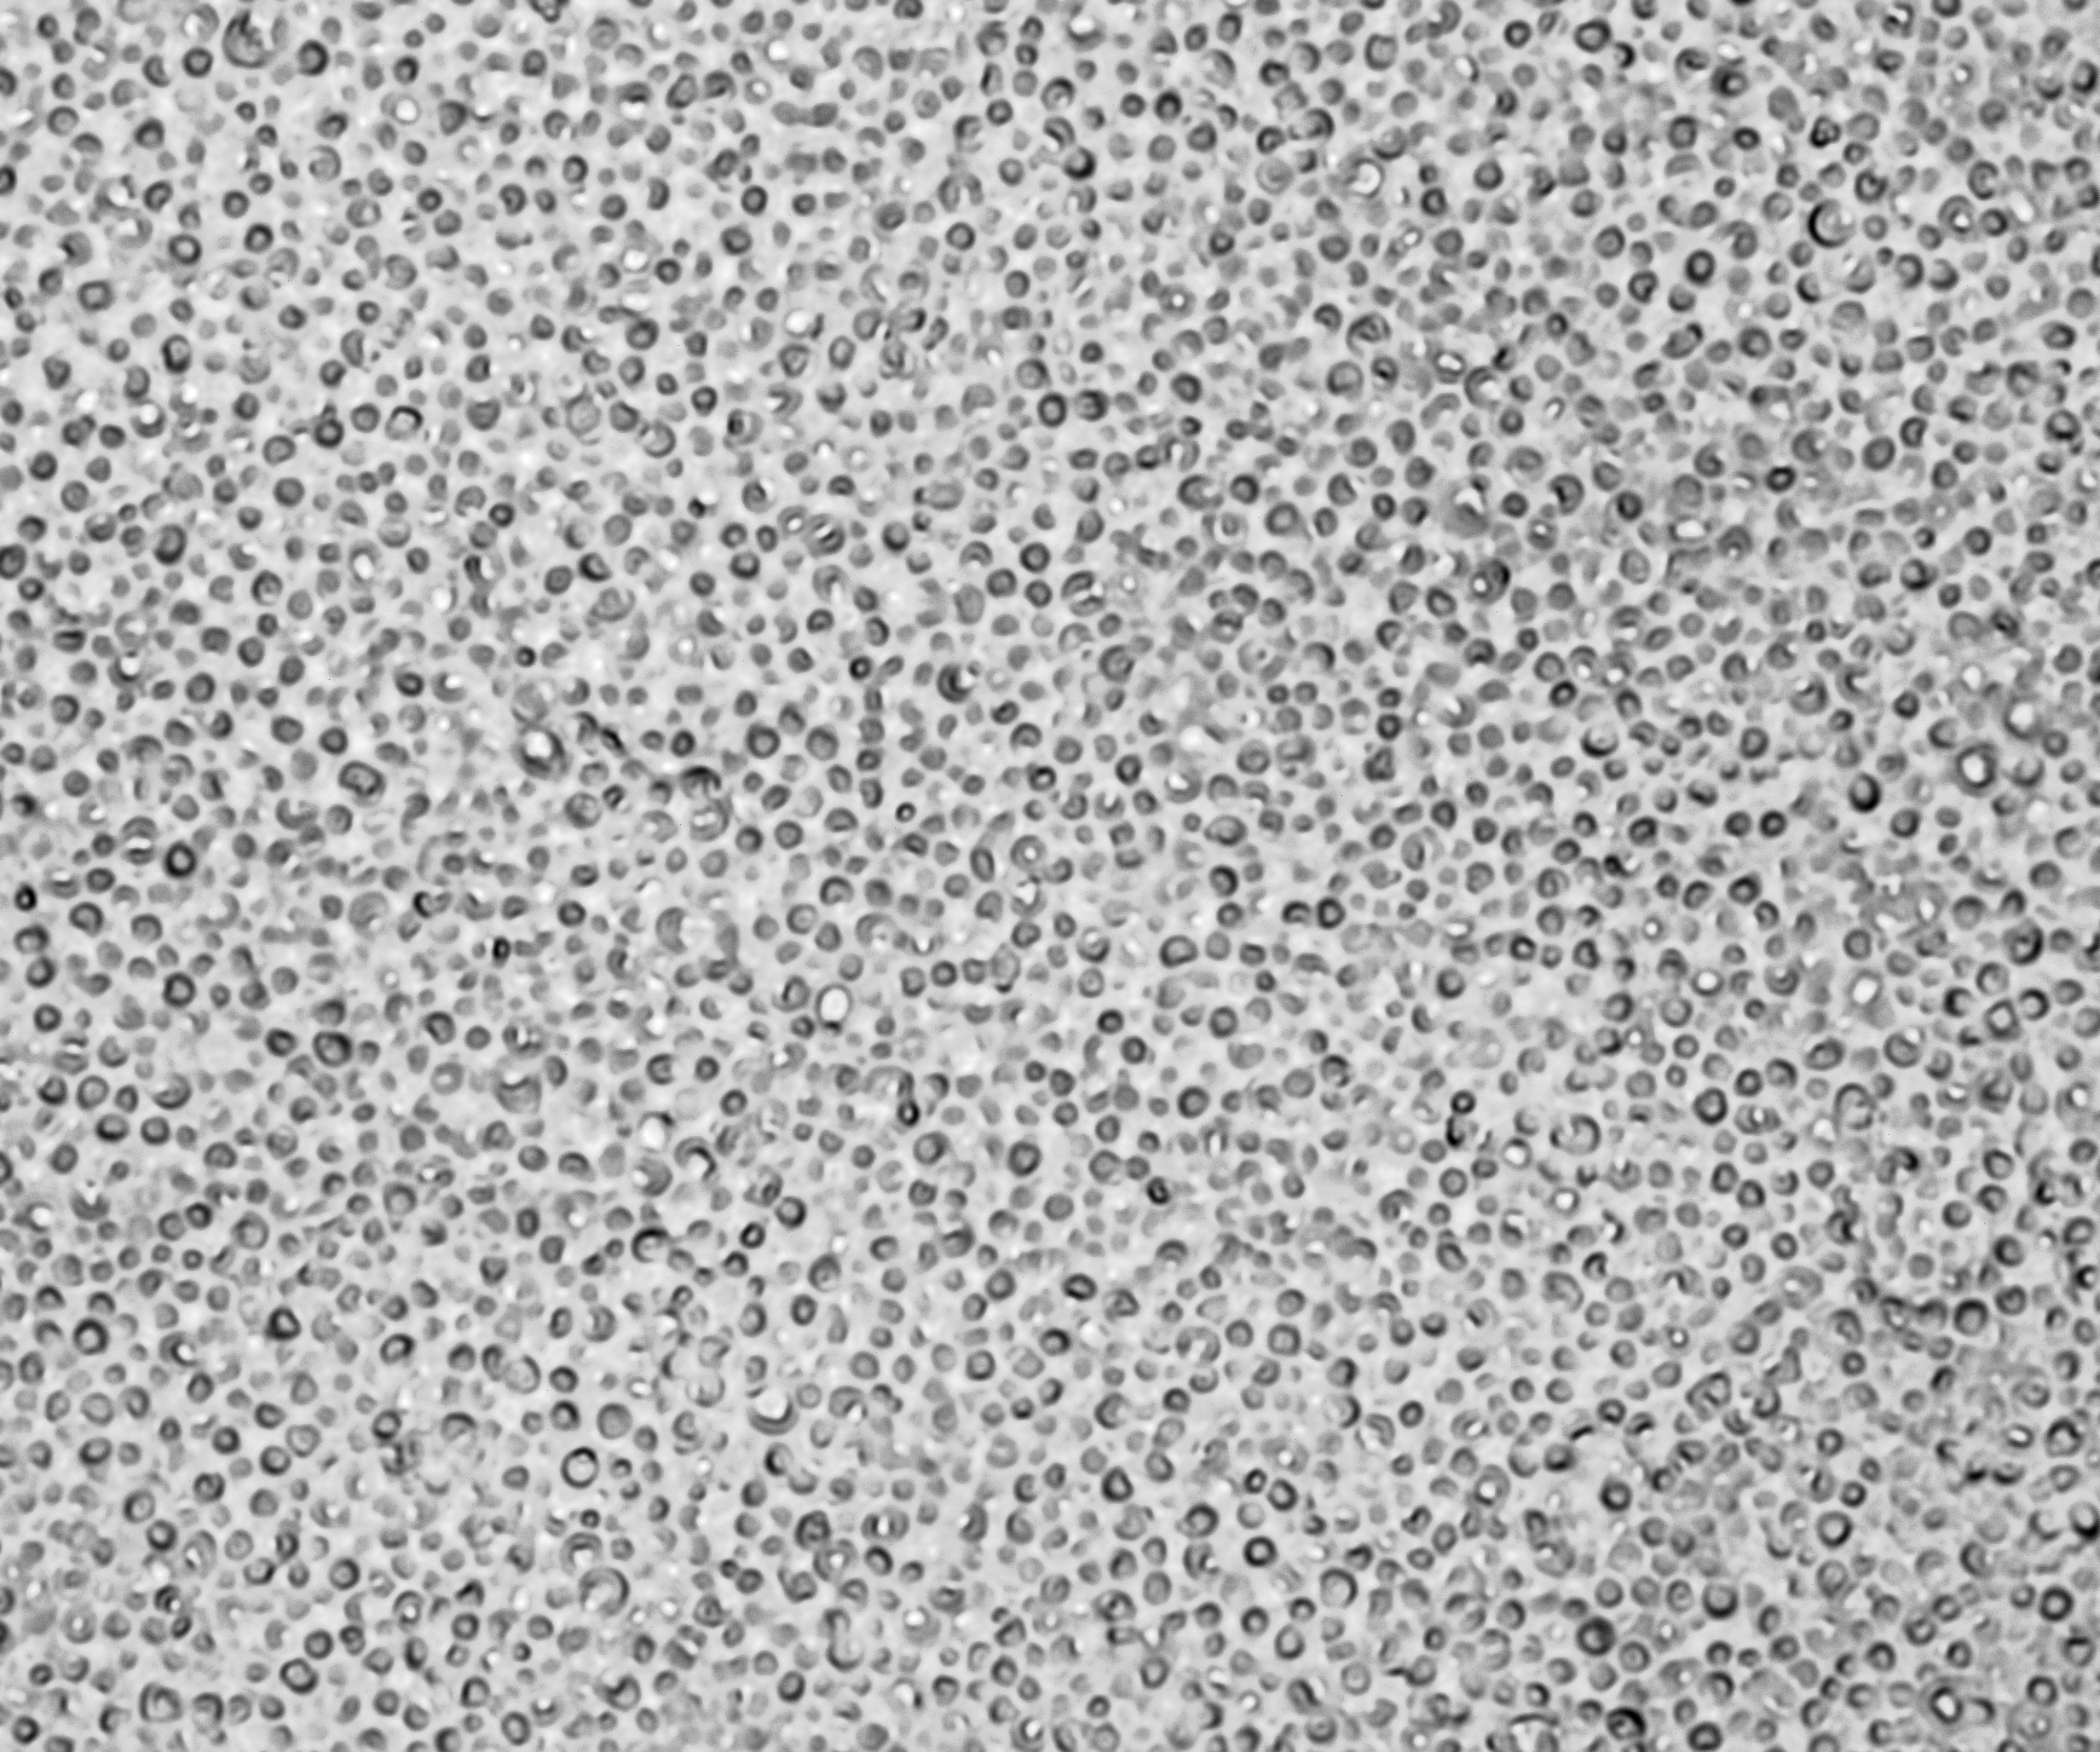

In [11]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)


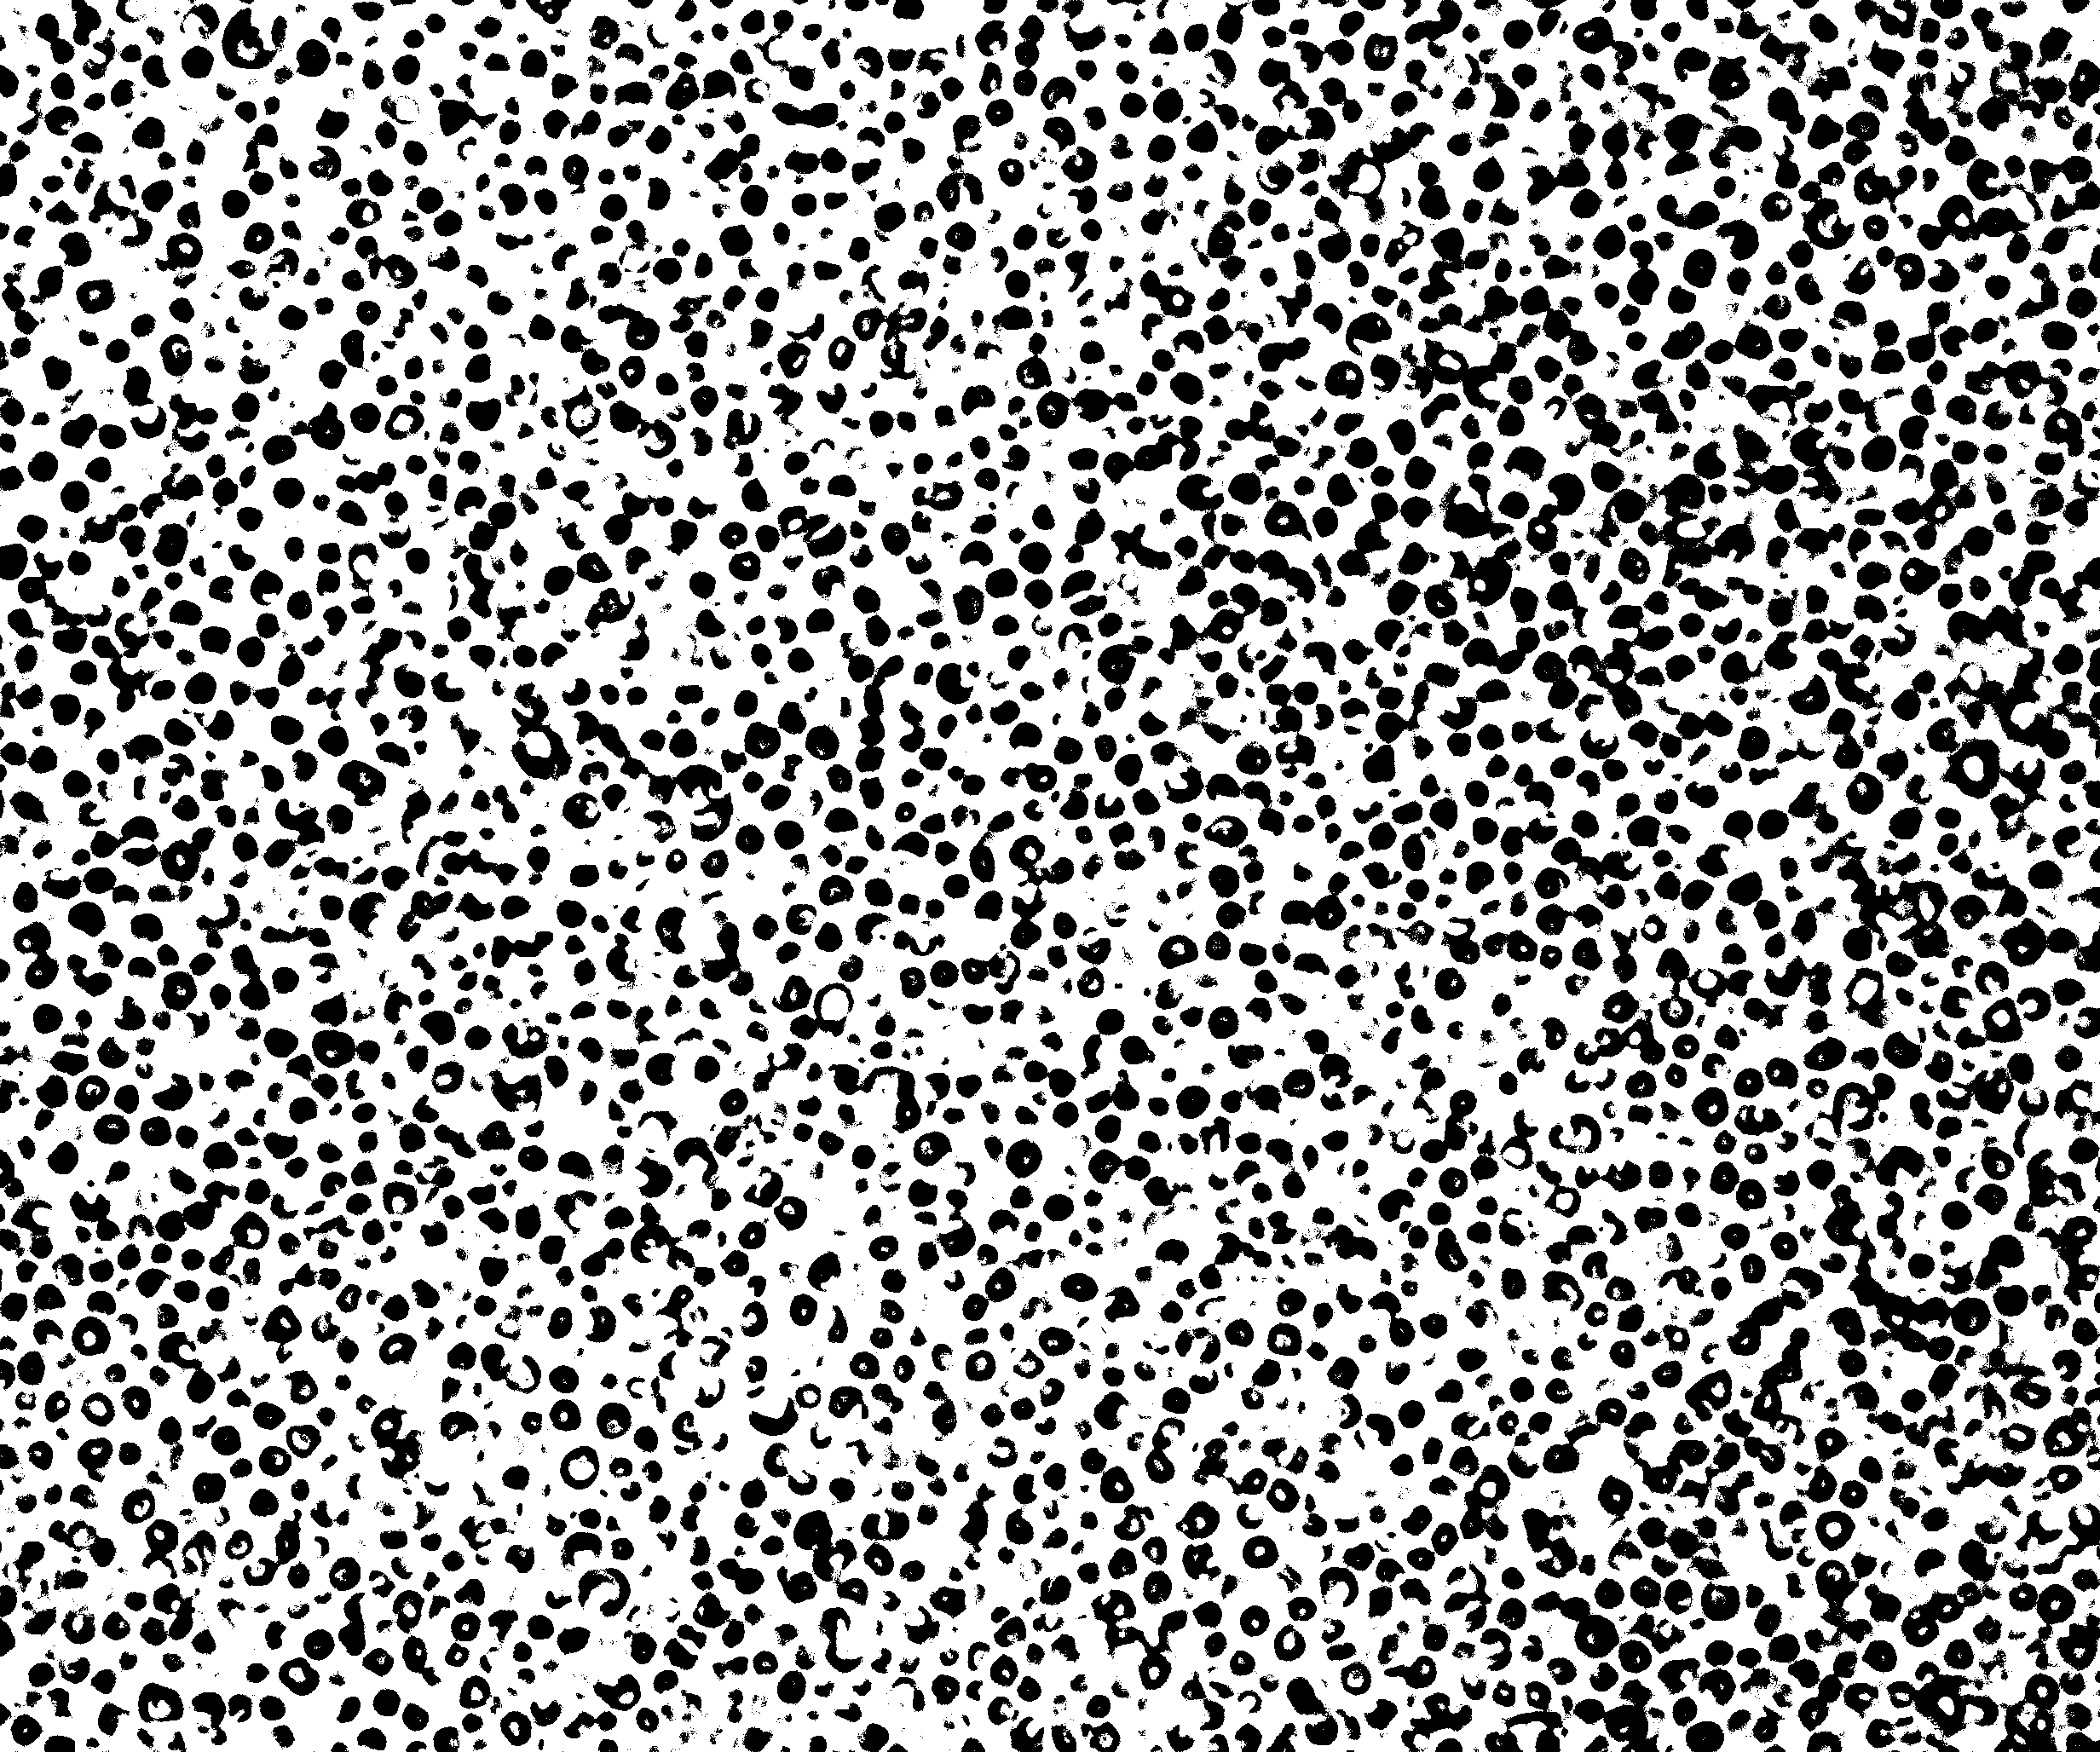

In [12]:
ret, thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2_imshow(thresh_img)


In [ ]:
import cv2
import numpy as np

# Read the binary image
#image = cv2.imread('your_bw_image.png')  # Replace with your image path

# Convert to grayscale (if needed)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray=thresh_img
# Threshold to obtain a binary image
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate area and perimeter for each object
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)  # True for closed contour
    print("Area = {}, Perimeter = {}".format(area, perimeter))


In [ ]:
import numpy as np
from skimage import io, measure

# Read the binary image
#image = io.imread('your_bw_image.png')  # Replace with your image path

# Label connected components (equivalent to MATLAB's bwlabel)
image=thresh_img
labeled_image, num_objects = measure.label(image, background=0, return_num=True)

# Calculate area and perimeter for each object
properties = measure.regionprops(labeled_image, image)

for prop in properties:
    area = prop.area
    perimeter = prop.perimeter
    print("Object #{}: Area = {}, Perimeter = {}".format(prop.label, area, perimeter))


In [ ]:
gray=gray_img
# Threshold to obtain a binary image
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out contours with zero area and print remaining objects
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 0:  # Only consider contours with non-zero area
        perimeter = cv2.arcLength(cnt, True)
        print("Area = {}, Perimeter = {}".format(area, perimeter))


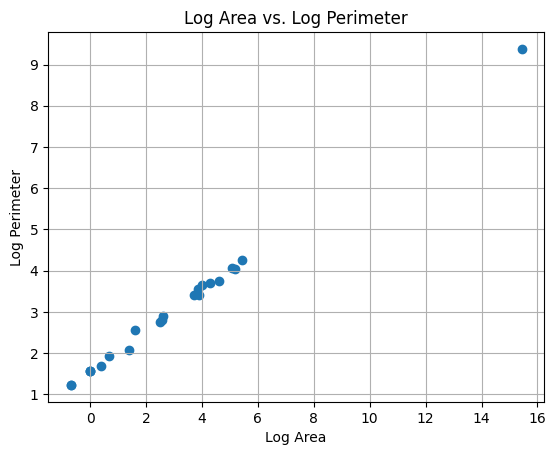

Slope (power term): 1.6539665116660158
Intercept (scale factor): 4.682700515433417


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

gray = gray_img

# Threshold to obtain a binary image
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty list to store object data
data = []

# Filter contours, calculate area, perimeter, and store data
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 0:
        perimeter = cv2.arcLength(cnt, True)
        data.append({'area': area, 'perimeter': perimeter})

# Check if any objects were found
if not data:
    print("No objects with non-zero area were found!")
else:
    # Create a pandas DataFrame from the data list
    df = pd.DataFrame(data)

    # Calculate log area and log perimeter
    df['log_area'] = np.log(df['area'])
    df['log_perimeter'] = np.log(df['perimeter'])

    # Plot log area vs log perimeter
    plt.scatter(df['log_area'], df['log_perimeter'])
    plt.xlabel('Log Area')
    plt.ylabel('Log Perimeter')
    plt.title('Log Area vs. Log Perimeter')
    plt.grid(True)
    plt.show()

    # Fit a linear regression model (assuming a power law relationship)
    m, c = np.linalg.lstsq(np.vstack([df['log_area'], np.ones(len(df))]).T, df['log_perimeter'], rcond=None)[0]

    # Calculate slope and intercept (anti-log of regression coefficients)
    slope = np.exp(m)
    intercept = np.exp(c)

    print("Slope (power term):", slope)
    print("Intercept (scale factor):", intercept)

    # Save DataFrame to CSV (optional)
    # df.to_csv('object_data.csv', index=False)


In [ ]:
import numpy as np


def box_counting(image, epsilon):
  """
  Calculates the box dimension of a binary image using box counting.

  Args:
      image: A 2D NumPy array representing the binary image.
      epsilon: Minimum box size to consider (to avoid division by zero).

  Returns:
      A tuple containing:
          box_sizes: A list of box sizes used in the calculation.
          box_counts: A list of corresponding box counts for each size.
  """
  box_sizes = []
  box_counts = []
  height, width = image.shape

  # Iterate through potential box sizes
  for box_size in range(epsilon, min(height, width) // 2 + 1):
    # Count the number of boxes needed to cover the image
    box_count = 0
    for y in range(0, height, box_size):
      for x in range(0, width, box_size):
        # Check if the box overlaps a foreground pixel
        box = image[y:y+box_size, x:x+box_size]
        if np.any(box):
          box_count += 1

    box_sizes.append(box_size)
    box_counts.append(box_count)

  return box_sizes, box_counts





In [ ]:

def calculate_fractal_dimension(box_sizes, box_counts):
  """
  Calculates the fractal dimension from the box sizes and counts.

  Args:
      box_sizes: A list of box sizes used in the calculation.
      box_counts: A list of corresponding box counts for each size.

  Returns:
      The estimated fractal dimension of the image.
  """
  # Convert box sizes and counts to log scale
  log_box_sizes = np.log(box_sizes)
  log_box_counts = np.log(box_counts)

  # Perform linear regression to find the slope
  slope, lacun = np.polyfit(log_box_sizes, log_box_counts, 1)

  # Fractal dimension is negative of the slope
  fractal_dimension = -slope

  return fractal_dimension,lacun


In [ ]:
def main():
  # Load the image (replace with your image path)
  # image_path = "path/to/your/binary_image.jpg"
  # image = cv2.imread(image_path, 0)  # Read as grayscale

  # Convert to binary (if needed)
  # _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

  # Minimum box size to avoid division by zero
  epsilon = 1

  # Calculate box sizes and counts
  box_sizes, box_counts = box_counting(thresh_img, epsilon)

  # Calculate the fractal dimension
  fractal_dimension,lacun = calculate_fractal_dimension(box_sizes, box_counts)

  print("Estimated fractal dimension:", fractal_dimension,"lacunarity",lacun)

if __name__ == "__main__":
  main()


Estimated fractal dimension: 1.872133623246131 lacunarity 14.896307341588475


In [ ]:
# prompt: Can you make a table for alll images in in folder sample?

import pandas as pd
import os
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/ranjita2024/time/")

os.chdir("/content/drive/My Drive/ranjita2024/time/Cont")

images = os.listdir()

fractal_dimensions = []
lacunarities = []

for image_name in images:
    img = cv2.imread(image_name)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    box_sizes, box_counts = box_counting(thresh_img, 1)
    fractal_dimension, lacunarity = calculate_fractal_dimension(box_sizes, box_counts)

    fractal_dimensions.append(fractal_dimension)
    lacunarities.append(lacunarity)

# Create a table with image names, fractal dimensions, and lacunarities
table = pd.DataFrame({
    "Image Name": images,
    "Fractal Dimension": fractal_dimensions,
    "Lacunarity": lacunarities
})

print(table.to_string())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           Image Name  Fractal Dimension  Lacunarity
0      Control_48.tif           1.839021   13.410324
1    Control_00hr.tif           1.872134   14.896307
2      Control_24.tif           1.849871   13.474810
3      Control_72.tif           1.847797   13.464799
4  Control_03hr_4.tif           1.873936   14.907493


In [ ]:
# prompt: Can you make a table for alll images in in folder sample?

import pandas as pd
import os
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
import numpy as np



os.chdir("/content/drive/My Drive/ranjita2024/time/Samp")

images = os.listdir()

fractal_dimensions = []
lacunarities = []

for image_name in images:
    img = cv2.imread(image_name)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    box_sizes, box_counts = box_counting(thresh_img, 1)
    fractal_dimension, lacunarity = calculate_fractal_dimension(box_sizes, box_counts)

    fractal_dimensions.append(fractal_dimension)
    lacunarities.append(lacunarity)

# Create a table with image names, fractal dimensions, and lacunarities
table = pd.DataFrame({
    "Image Name": images,
    "Fractal Dimension": fractal_dimensions,
    "Lacunarity": lacunarities
})

print(table.to_string())


          Image Name  Fractal Dimension  Lacunarity
0   sample_48.hr.tif           1.877853   14.931576
1    sample_72hr.tif           1.878986   14.938571
2    sample_24hr.tif           1.865874   13.563391
3  Sample_03hr_3.tif           1.877643   14.930271
4  Sample_48hr_2.tif           1.880981   14.950817
